In [103]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN, OPTICS, SpectralClustering
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.linalg import svd, decomp_svd
from scipy.sparse import csc, csr, coo_matrix
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from matplotlib.ticker import FuncFormatter, Formatter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re

from io import BytesIO
from PIL import Image
import requests
from scipy.sparse.linalg import svds
import tqdm

### And we may start implementation & research of our recommendation systems techniques!
### !!! Here we go !!! @fabriziorom

### Firstly, let's read our datasets and completete preliminary data research.

In [ ]:
books = pd.read_csv('tools\\BX-Books.csv')
interactions = pd.read_csv("tools\\BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

In [4]:
interactions = interactions.drop_duplicates()

In [5]:
print(f"Initial length of all interactions: {len(interactions)}")
print(f"Initial length of all books: {len(books)}")

Initial length of all interactions: 1149780
Initial length of all books: 271360


In [6]:
interactions = interactions[interactions["Book-Rating"] != 0]
print(f"Length of non-null ratings: {len(interactions)}")

Length of non-null ratings: 433671


### From 1.1m to 4.33k interactions: data cut back.

In [7]:
interactions.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


In [8]:
print(f"Unique number of users: {interactions['User-ID'].nunique()}")

Unique number of users: 77805


In [9]:
print(f"Mean rate for all: {interactions['Book-Rating'].mean():.2f}")

Mean rate for all: 7.60


#### Ratings distribution:

Text(0.5, 1.0, 'Distribution for the Book-Ratings')

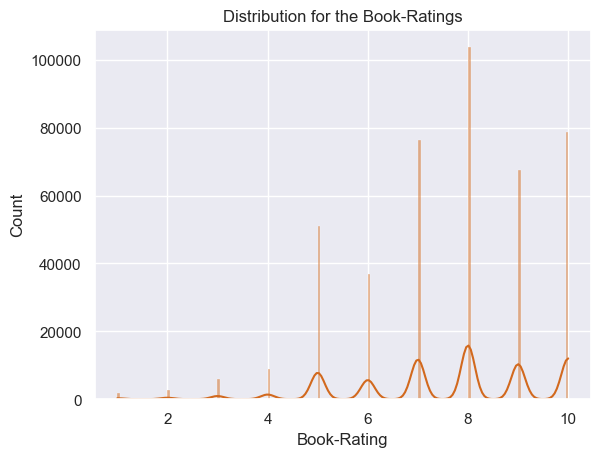

In [157]:
sns.histplot(data = interactions, x = 'Book-Rating', color = 'chocolate', kde = True)
plt.title('Distribution for the Book-Ratings')

#### Mostly we have greater than 5 ratings. Further we'll filter data from low-rated books, cause our goal is to recommend high-rated instances. 

#### Let's check for number of users to react on the book:

In [10]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [11]:
books_meets.head()

,ISBN,user_num
0,0330299891,1
1,0375404120,1
2,9022906116,1
3,#6612432,1
4,'9607092910',1


In [12]:
books_meets[books_meets['ISBN'] == '0425180433']

,ISBN,user_num
51736,0425180433,6


In [13]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [133]:
user_meets.head()

,User-ID,books_num
0,8,7
1,9,1
2,10,1
3,12,1
4,14,3


In [14]:
len(user_meets)

77805

In [15]:
print(f"Mean books_num estimated: {user_meets['books_num'].mean()}")
print(f"Max books_num estimated: {user_meets['books_num'].max()}")
print(f"Max books_num estimated: {user_meets['books_num'].min()}")

Mean books_num estimated: 5.573819163292847
Max books_num estimated: 8524
Max books_num estimated: 1


In [16]:
print(f"99% quantile of num_books rated: {np.quantile(user_meets['books_num'], 0.99)}")

99% quantile of num_books rated: 73.0


#### Merge interactions, books_meets & user_meets:

In [17]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [18]:
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num
0,276726,0155061224,5,1,1
1,276729,052165615X,3,1,2
2,276729,0521795028,6,1,2
3,276736,3257224281,8,4,1
4,86583,3257224281,6,4,18


#### And filter by books_num & user_num to achieve objective & clean results:

In [19]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 2) &
                            (interactions["books_num"] < 200)]

In [20]:
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num
5,86583,3404139178,9,8,18
6,86583,3453061187,8,13,18
13,86583,3426609061,7,8,18
8555,16877,038550120X,9,81,10
8556,16877,034539657X,7,26,10


In [21]:
print(f"Unique number of Users: {interactions['User-ID'].nunique()}")
print(f"Unique number of Books presented: {interactions['ISBN'].nunique()}")

Unique number of Users: 19339
Unique number of Books presented: 11247


#### Have a look on updated ratings distribution:

Text(0.5, 1.0, 'Updated Book-Rated Distribution')

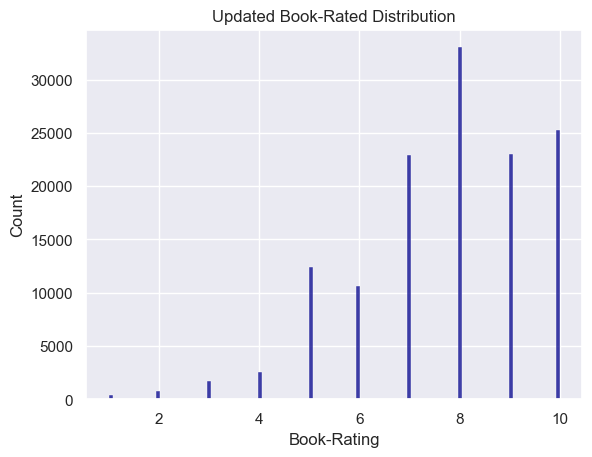

In [172]:
sns.histplot(data = interactions, x = 'Book-Rating', color = 'darkblue')
plt.title('Updated Book-Rated Distribution')

#### User_num per book distribution:

In [22]:
len(interactions[['ISBN', 'user_num']]), len(interactions[['ISBN', 'user_num']].drop_duplicates())

(132569, 11247)

Text(0.5, 1.0, 'Updated user_num distribution')

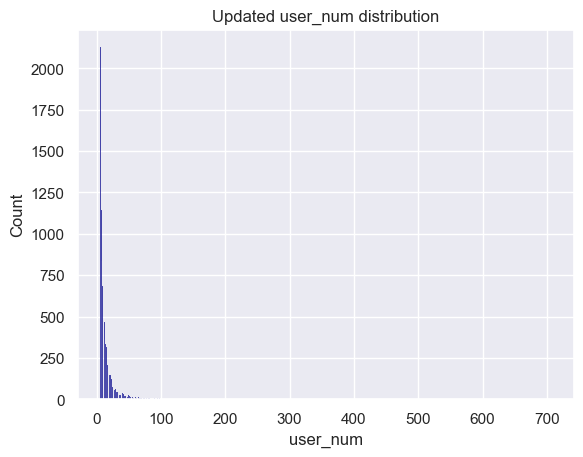

In [174]:
sns.histplot(data = interactions[['ISBN', 'user_num']].drop_duplicates(), x = 'user_num', color = 'darkblue')
plt.title('Updated user_num distribution')

#### Books_num distribution:

Text(0.5, 1.0, 'Updated books_num distribution')

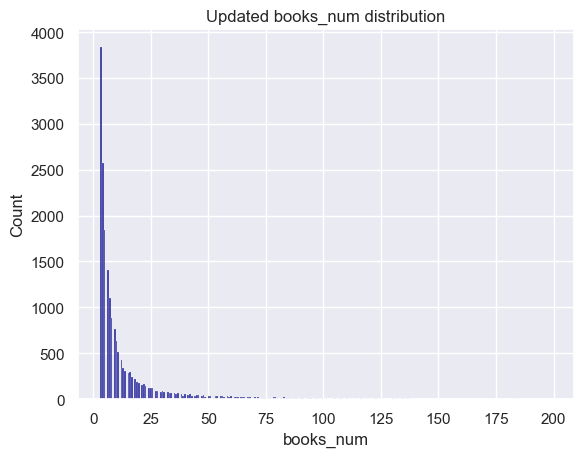

In [175]:
sns.histplot(data = interactions[['User-ID', 'books_num']].drop_duplicates(), x = 'books_num', color = 'darkblue')
plt.title('Updated books_num distribution')

#### So, what's about the users info?

In [4]:
users = pd.read_csv('tools\\BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')

In [25]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [26]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [27]:
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman


In [28]:
le = preprocessing.LabelEncoder()

In [29]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [28]:
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,5970
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,9121
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,4590
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,18842
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,7335


In [30]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

#### Let's have a look on nunique values of Books:

In [31]:
print(f"Books_unique number: {interactions['Book-Title'].nunique()}")

Books_unique number: 9481


In [32]:
print(f"Total interactions : {len(interactions)}")

Total interactions : 128505


#### What's about books?

In [32]:
books_main_info = books[['ISBN', 'Book-Author', 'Year-Of-Publication']]
books_main_info.head()

,ISBN,Book-Author,Year-Of-Publication
0,0195153448,Mark P. O. Morford,2002
1,0002005018,Richard Bruce Wright,2001
2,0060973129,Carlo D'Este,1991
3,0374157065,Gina Bari Kolata,1999
4,0393045218,E. J. W. Barber,1999


#### Let's denote the total interactions DataFrame, including reviewer's age, location and all additional info about the book:

In [33]:
total_interactions = interactions.merge(books_main_info, on=["ISBN"])
total_interactions.head(3)

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid,Book-Author,Year-Of-Publication
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,5970,Rebecca Gable,1997
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,9121,Rebecca Gable,1997
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,4590,Rebecca Gable,1997


In [154]:
total_interactions_age_included = total_interactions.merge(users, on=["User-ID"])
total_interactions_age_included.head(3)

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid,Book-Author,Year-Of-Publication,Location,Age
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,5970,Rebecca Gable,1997,"stuttgart, , germany",31.0
1,86583,3453061187,8,13,18,http://images.amazon.com/images/P/3453061187.0...,Die Jury. Roman.,10504,5970,John Grisham,1992,"stuttgart, , germany",31.0
2,86583,3426609061,7,8,18,http://images.amazon.com/images/P/3426609061.0...,House Of God.,10436,5970,Samuel Shem,1998,"stuttgart, , germany",31.0


#### Now, we should have a look on 'Location' column:

In [155]:
print(f"Number of unique Locations: {total_interactions_age_included['Location'].nunique()}")
print(f"Total number of Locations: {total_interactions_age_included['Location'].count()}")

Number of unique Locations: 7431
Total number of Locations: 128505


In [156]:
total_interactions_age_included['Location'] = total_interactions_age_included['Location'].str.replace('[^\w\s]', 
                                                                                                      '',
                                                                                                      regex = True)

In [157]:
total_interactions_age_included['Location'].head(10)

0       stuttgart  germany
1       stuttgart  germany
2       stuttgart  germany
3                   fürth 
4                   fürth 
5                   fürth 
6                   fürth 
7                   fürth 
8    berlin berlin germany
9    berlin berlin germany
Name: Location, dtype: object

#### Age contains NaN values. We should replace them after some analysis:

In [158]:
print(f"Age column NaN values: {len(total_interactions_age_included[total_interactions_age_included['Age'].isna() == True])}")
print(f"Age column len(): {len(total_interactions_age_included['Age'])}")

Age column NaN values: 35532
Age column len(): 128505


#### Let's try to view whether the Book's Author impacts on Age of reviewers:

In [159]:
total_interactions_age_included['author_id'] = le.fit_transform(total_interactions_age_included["Book-Author"])
total_interactions_age_included.head(3)

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid,Book-Author,Year-Of-Publication,Location,Age,author_id
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10405,5970,Rebecca Gable,1997,stuttgart germany,31.0,2926
1,86583,3453061187,8,13,18,http://images.amazon.com/images/P/3453061187.0...,Die Jury. Roman.,10504,5970,John Grisham,1992,stuttgart germany,31.0,1753
2,86583,3426609061,7,8,18,http://images.amazon.com/images/P/3426609061.0...,House Of God.,10436,5970,Samuel Shem,1998,stuttgart germany,31.0,3152


#### Build smth like barplot:

Text(0.5, 1.0, 'Author-Id-Mean-Age distribution')

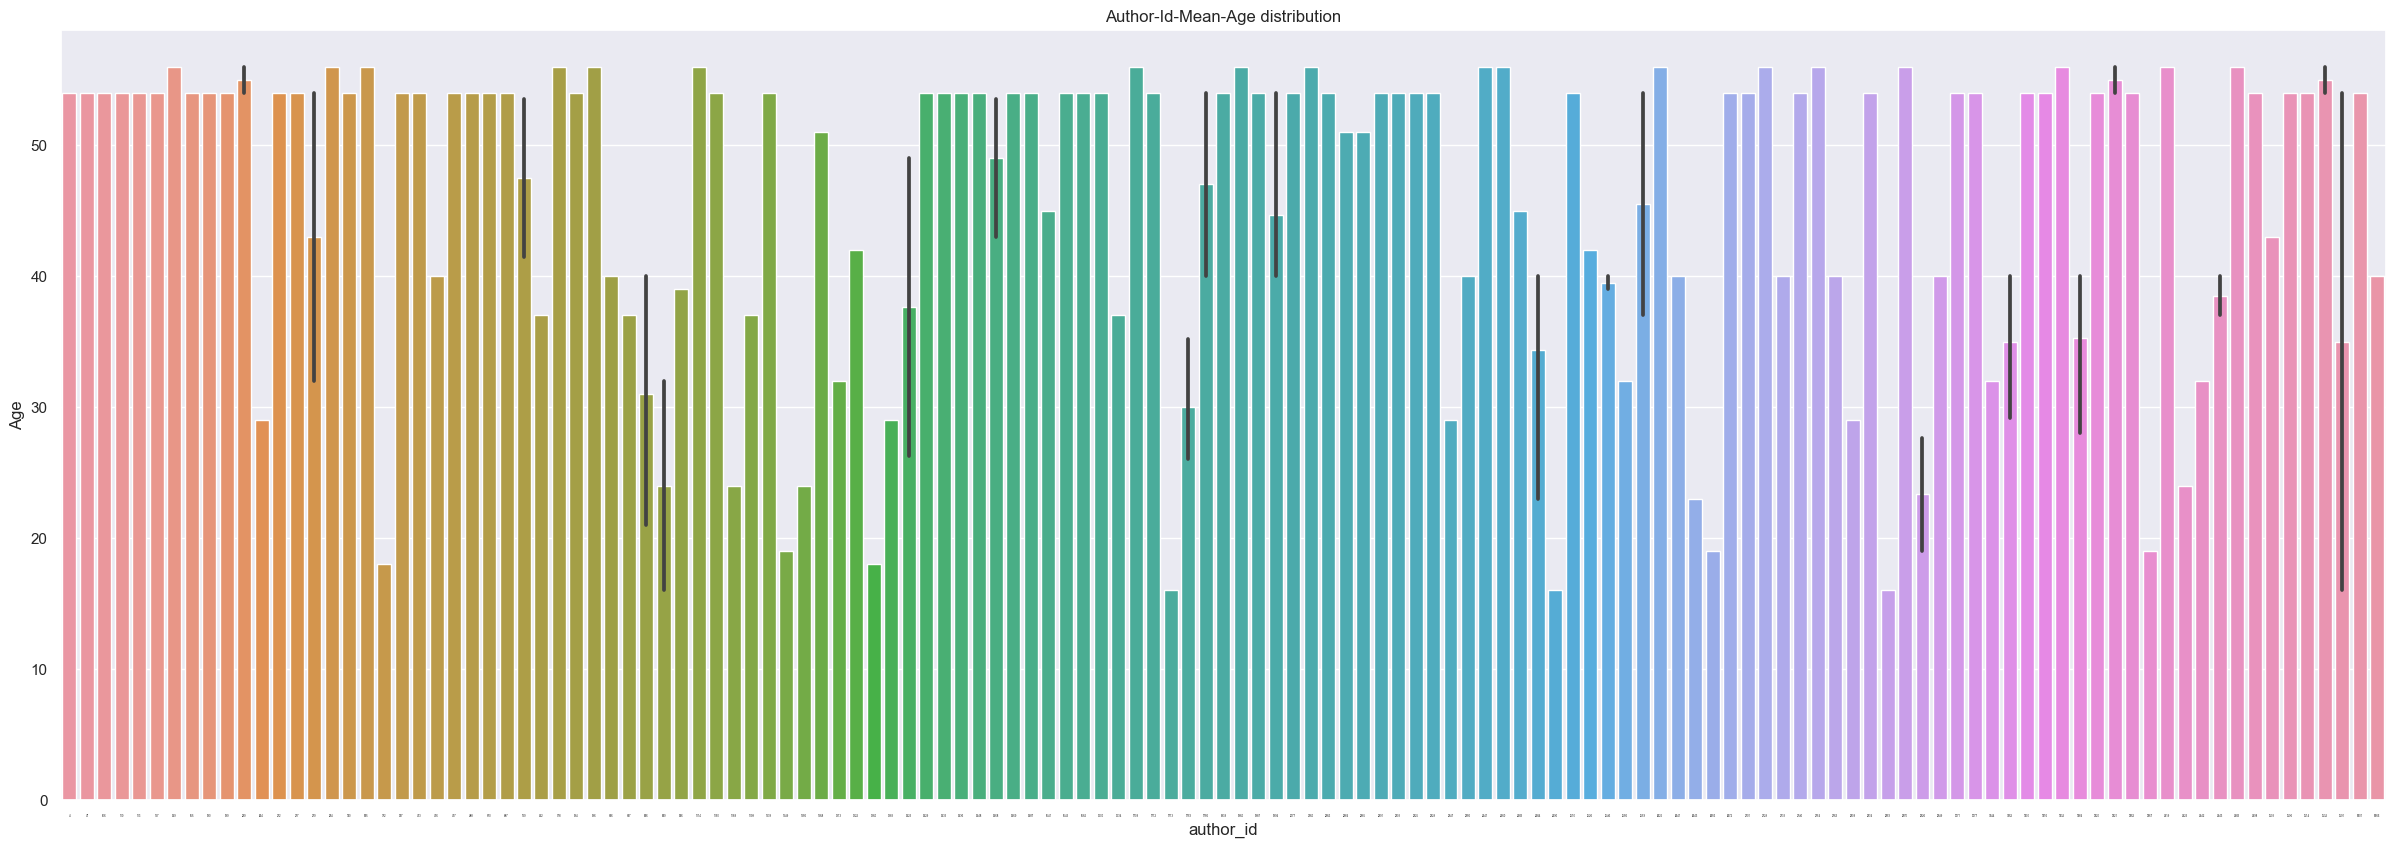

In [40]:
figure = plt.figure(figsize = (30, 10))
sns.barplot(data = total_interactions_age_included[total_interactions_age_included['Age'].isna() == False].iloc[:200, :],
            x = 'author_id',
            y = 'Age')
plt.xticks(fontsize = 2)
plt.title('Author-Id-Mean-Age distribution')

#### Ok, the heterogenity shown on the barplot for 200 samples. That's why we assume each author to have his own age target audience. Tryna replace NaN values by Author's mean Age:

In [160]:
mean_age_by_author = total_interactions_age_included\
    .groupby('author_id')['Age']\
    .mean()\
    .reset_index()\
    .rename(columns={"Age": "mean_age"})

In [161]:
mean_age_by_author_dict = dict(zip(mean_age_by_author['author_id'], mean_age_by_author['mean_age']))

In [163]:
total_interactions_age_included['Age'] = total_interactions_age_included['Age'] \
    .fillna(total_interactions_age_included['author_id'].map(mean_age_by_author_dict))

In [164]:
print(f"Number of NaN Age values *updated*: {len(total_interactions_age_included[total_interactions_age_included['Age'].isna() == True])}")

Number of NaN Age values *updated*: 42


#### Here we got 42 NaN values at least:

In [165]:
total_interactions_age_included[total_interactions_age_included['Age'].isna() == True].tail(1)['Book-Title'].values

array(['Why Your Life Sucks:  And What You Can Do About It'], dtype=object)

#### So, it means that there's no information at all about the target age of the audience. May be we should try to know how to predict the age using the Book-Title information. 
#### Idk should we actually do that (probably the simplest way is to just drop this rows), but we're Machine Leearning Engineers. Let's have a try to build the regressor with word2vec. Why Not?

In [166]:
age_not_nan = total_interactions_age_included[total_interactions_age_included['Age'].isna() == False]
age_nan = total_interactions_age_included[total_interactions_age_included['Age'].isna() == True]
print(f"Number of NotNaN ages: {len(age_not_nan)}")

Number of NotNaN ages: 128463


In [167]:
print(f"Number of NaN ages: {len(age_nan)}")

Number of NaN ages: 42


#### But before let's have a look on the Age distribution:

In [168]:
print(f"Min Age: {total_interactions_age_included['Age'].min()}")
print(f"Max Age: {total_interactions_age_included['Age'].max()}")
print(f"Mean Age: {total_interactions_age_included['Age'].mean()}")

Min Age: 0.0
Max Age: 244.0
Mean Age: 36.517412782111094


Text(0.5, 1.0, 'Age distribution')

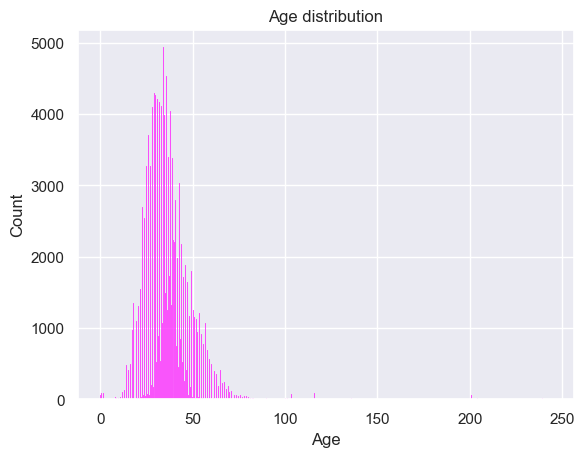

In [106]:
sns.histplot(data = total_interactions_age_included, x = 'Age', color = 'magenta')
plt.title('Age distribution')

In [169]:
isna_false = total_interactions_age_included[total_interactions_age_included['Age'].isna() == False]['Age']
quantile = 0.015
print(f"Age {quantile} quantile: {np.quantile(isna_false, quantile)}")

quantile = 0.975
print(f"Age {quantile} quantile: {np.quantile(isna_false, quantile)}")

Age 0.015 quantile: 16.0
Age 0.975 quantile: 62.0


#### And filter not interesting Ages:

In [170]:
total_interactions_age_included = total_interactions_age_included[(total_interactions_age_included['Age'] >=16) &
                                                                  (total_interactions_age_included['Age'] <=62) |
                                                                  (total_interactions_age_included['Age'].isna() == True)]

In [171]:
print(f"Number of NaN ages: {len(total_interactions_age_included[total_interactions_age_included['Age'].isna() == True])}")

Number of NaN ages: 42


#### And histplot again:

Text(0.5, 1.0, 'Age distribution *updated*')

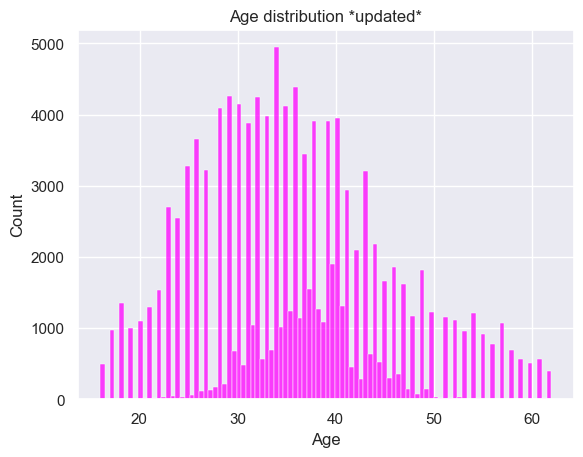

In [113]:
sns.histplot(data = total_interactions_age_included, x = 'Age', color = 'magenta')
plt.title('Age distribution *updated*')

#### That's it. Continue with texts:

In [172]:
age_not_nan = total_interactions_age_included[total_interactions_age_included['Age'].isna() == False]
age_nan = total_interactions_age_included[total_interactions_age_included['Age'].isna() == True]

In [173]:
age_not_nan.shape, age_nan.shape

((124021, 14), (42, 14))

In [117]:
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z]', ' ', text).lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens]
    return tokens

corpus_titles = age_not_nan[['Book-Title']].applymap(preprocess_text)
corpus_titles_nan = age_nan[['Book-Title']].applymap(preprocess_text)

In [118]:
total_list = list(corpus_titles['Book-Title']) +  list(corpus_titles_nan['Book-Title'])

In [119]:
vector_size = 200

In [120]:
model_word2vec = Word2Vec(total_list,
                          vector_size=vector_size,
                          window = 5, min_count = 1, sg = 0)
model_word2vec.train(total_list, total_examples = len(total_list),
                     epochs = 30)

(14469995, 18768270)

In [123]:
model_word2vec.wv.most_similar('finn')

[('huckleberry', 0.9809094071388245),
 ('emerald', 0.8356122970581055),
 ('castafiore', 0.7979000210762024),
 ('tintin', 0.765967607498169),
 ('sawyer', 0.7197468876838684),
 ('kavalier', 0.714314877986908),
 ('skywalker', 0.6432481408119202),
 ('character', 0.6366966962814331),
 ('newton', 0.6155534982681274),
 ('scottish', 0.6001098155975342)]

In [124]:
def text_to_vector(text):
    vector = []
    for word in text:
        if word in model_word2vec.wv:
            vector.append(model_word2vec.wv[word])
    return np.mean(vector, axis = 0) if vector else np.zeros(shape=(vector_size,))

X_vectors = [text_to_vector(text) for text in list(corpus_titles['Book-Title'])]

In [125]:
X = np.asarray(X_vectors)
y = age_not_nan['Age']

In [126]:
X.shape, y.shape

((124021, 200), (124021,))

In [127]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = False)

In [128]:
age_regressor = XGBRegressor(n_estimators = 200)
age_regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [129]:
print(f"MAE age error: {mean_absolute_error(y_true = Y_test, y_pred = age_regressor.predict(X_test))}")

MAE age error: 6.613472749102765


Text(0.5, 0, 'Absolute error')

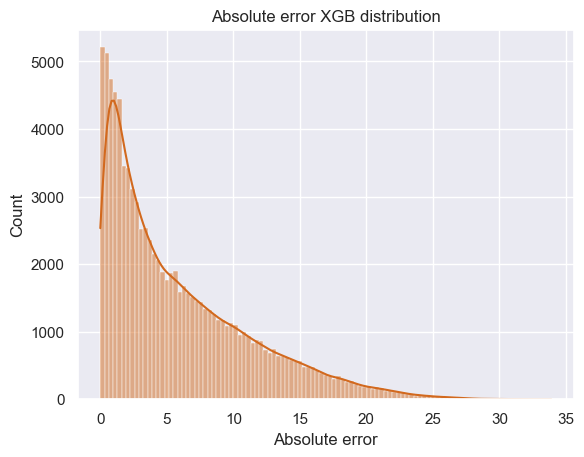

In [130]:
error = np.abs(Y_train - age_regressor.predict(X_train))
sns.histplot(x = error, color = 'chocolate', kde = True)
plt.title('Absolute error XGB distribution')
plt.xlabel('Absolute error')

In [75]:
mask = (error < np.quantile(error, 0.99))
age_regressor_update = XGBRegressor(n_estimators = 150,
                             objective = 'reg:squarederror')
age_regressor_update.fit(X_train[mask], Y_train[mask])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
print(f"MAE age error: {mean_absolute_error(y_true = Y_test, y_pred = age_regressor_update.predict(X_test))}")

MAE age error: 6.590192927081277


#### On full data:

In [175]:
age_regressor = XGBRegressor(n_estimators = 200)
age_regressor.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Ok, probably we'll mistake for approximately 6 years of age... Guess, it's not problem at all. That's why let's have a try to predict NaN ages using the titles:

In [184]:
X_vectors_age_nan = [text_to_vector(text) for text in list(corpus_titles_nan['Book-Title'])]
X_vectors_age_nan_numpy = np.asarray(X_vectors_age_nan)
y_replace = age_regressor.predict(X_vectors_age_nan_numpy)
y_replace = y_replace.astype(int)

In [219]:
y_replace

array([33, 37, 36, 35, 36, 37, 31, 31, 35, 34, 33, 35, 35, 38, 36, 35, 38,
       31, 37, 33, 43, 36, 33, 43, 35, 37, 31, 41, 37, 33, 35, 37, 36, 37,
       37, 36, 37, 35, 34, 31, 41, 41])

#### Pretty good values => let's replace NaNs:

In [224]:
total_interactions_age_included.loc[total_interactions_age_included['Age'].isna() == True, 'Age'] = y_replace

In [225]:
print(f"Number of NaN ages: {len(total_interactions_age_included[total_interactions_age_included['Age'].isna() == True])}")

Number of NaN ages: 0


#### Let's check for the NaN in columns and local save the file to continue tomorrow!

In [228]:
for column in total_interactions_age_included.columns:
    print(f"Column {column}:")
    print(f"Number of NaNs: {len(total_interactions_age_included[total_interactions_age_included[column].isna() == True])}")
    print()

Column User-ID:
Number of NaNs: 0

Column ISBN:
Number of NaNs: 0

Column Book-Rating:
Number of NaNs: 0

Column user_num:
Number of NaNs: 0

Column books_num:
Number of NaNs: 0

Column picture_url:
Number of NaNs: 0

Column Book-Title:
Number of NaNs: 0

Column product_id:
Number of NaNs: 0

Column vid:
Number of NaNs: 0

Column Book-Author:
Number of NaNs: 0

Column Year-Of-Publication:
Number of NaNs: 0

Column Location:
Number of NaNs: 0

Column Age:
Number of NaNs: 0

Column author_id:
Number of NaNs: 0



#### Totally correct! Let's finally save that:

In [229]:
total_interactions_age_included.to_csv('total_interactions_age_included.csv')

#### Keep fit & continue:

In [34]:
total_interactions_age_included = pd.read_csv('tools\\total_interactions_age_included.csv')
total_interactions_age_included = total_interactions_age_included.drop(columns = ['Unnamed: 0'])

In [3]:
for column in total_interactions_age_included.columns:
    print(f"Column {column}:")
    print(f"Number of NaNs: {len(total_interactions_age_included[total_interactions_age_included[column].isna() == True])}")
    print()

Column User-ID:
Number of NaNs: 0

Column ISBN:
Number of NaNs: 0

Column Book-Rating:
Number of NaNs: 0

Column user_num:
Number of NaNs: 0

Column books_num:
Number of NaNs: 0

Column picture_url:
Number of NaNs: 0

Column Book-Title:
Number of NaNs: 0

Column product_id:
Number of NaNs: 0

Column vid:
Number of NaNs: 0

Column Book-Author:
Number of NaNs: 0

Column Year-Of-Publication:
Number of NaNs: 0

Column Location:
Number of NaNs: 0

Column Age:
Number of NaNs: 0

Column author_id:
Number of NaNs: 0



#### Ok, let's again look at the age's distribution:

Text(0.5, 1.0, "Age's distribution")

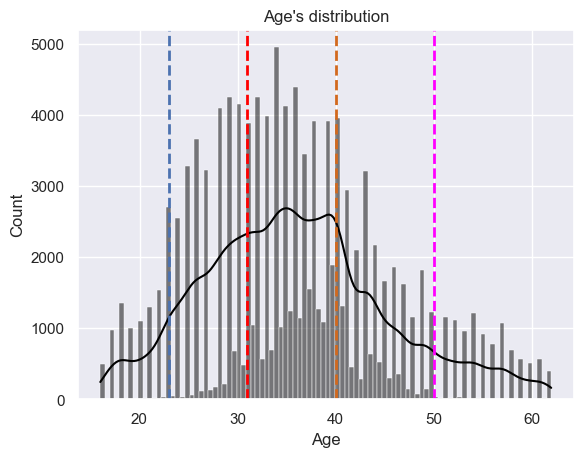

In [4]:
sns.histplot(data = total_interactions_age_included, x = 'Age', color = 'black', kde = True)
plt.axvline(x=23, linestyle = '--', linewidth = 2)
plt.axvline(x=31, linestyle = '--', color = 'red', linewidth = 2)
plt.axvline(x=40, linestyle = '--', color = 'chocolate', linewidth = 2)
plt.axvline(x=50, linestyle = '--', color = 'magenta', linewidth = 2)
plt.title("Age's distribution")

#### There are heterogeneity in age as we may notice and we should replace each ages by the group the age belongs to. I won't try to reinvent the wheel and just assume some age groups (5: you may see that on plot above) for reviewers:

In [35]:
def age_group_encoding(age):
    if (age < 23):
        return 'students & teens'
    elif (23 <= age < 31):
        return 'immature adults'
    elif (31 <= age < 40):
        return 'citizens'
    elif (40 >= age < 50):
        return 'pre-retired'
    else:
        return 'old'

total_interactions_age_included['age_group'] = total_interactions_age_included[['Age']].applymap(age_group_encoding)

#### And barplot again:

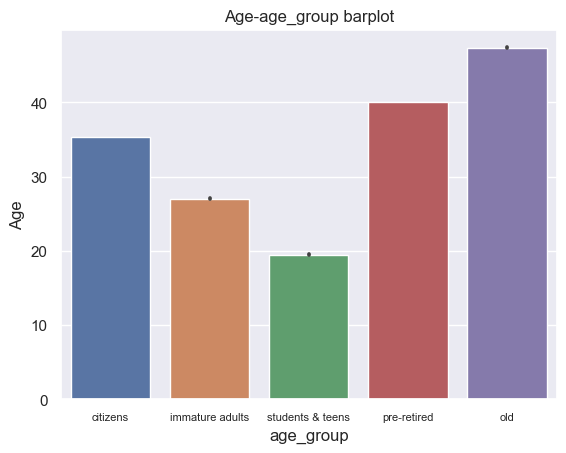

In [36]:
sns.barplot(data = total_interactions_age_included, x = 'age_group', y = 'Age')
plt.title('Age-age_group barplot')
plt.xticks(fontsize = 8)
plt.show()

In [37]:
label_encoding = LabelEncoder()
total_interactions_age_included['age_group_id'] = label_encoding.fit_transform(total_interactions_age_included['age_group'])

In [38]:
len(total_interactions_age_included)

124063

#### And before we start let's denote some plotting tools:

In [164]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, title_book, book_author, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        # fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            # try:
            #     r = requests.get(i)
            #     im = Image.open(BytesIO(r.content))
            #     print('Here')
            # except:
            #     print('Something went wrong with {url}'.format(url=i))
            #     continue
            # a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                print(f"{cnt}. Book's title: {title_book[cnt]}")
                print(f"Book's author: {book_author[cnt]}")
                print("measure = {}".format(np.round(measure[cnt], 4)))
                print()
                cnt += 1
        #     plt.imshow(im)
        #     plt.axis('off')
        # plt.show()

In [75]:
columns_needed = ['Book-Rating', 
                  'picture_url',
                  'Book-Title',
                  'Book-Author',
                  'age_group',
                  'age_group_id',
                  'Location',
                  'product_id',
                  'vid'
                  ]
total_interactions_for_top = total_interactions_age_included[columns_needed]

### Task 1

### Реализовать персональный топ  - принимает на вход возраст и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

In [165]:
# input_set = {'usa', 'florida'}
def is_subset(set_example, input_str):
    return input_str.issubset(set_example)

def location_split(x):
    return set(x.split())

In [171]:
class Top():
    def __init__(self, Int):
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def top_items(self, input_string, age):
        items = self.interactions.groupby(['Location', 'age_group_id']).agg({'product_id': 'first',
                                                                      'Book-Rating': 'mean',
                                                                      'Book-Title': 'first',
                                                                      'Book-Author': 'first'
                                                                      }).reset_index()\
                                                                        .sort_values("Book-Rating", ascending=False)
        
        input_set = set(input_string.split())                                                              
        items['Location_splitted'] = items[['Location']].applymap(location_split)
        items['true_location'] = items['Location_splitted'].apply(lambda x: is_subset(x, input_set))
        located_items = items[items['true_location'] == True]
        age_string = age_group_encoding(age)
        encoded_age = label_encoding.transform(pd.Series(age_string))[0]
        age_located_items = located_items[located_items['age_group_id'] == encoded_age][:15]
        
        rec_imaging(age_located_items["product_id"].values, self.product_id_to_url,
                    age_located_items['Book-Title'].values,
                    age_located_items['Book-Author'].values,
                    age_located_items["Book-Rating"].values,
                    )

In [172]:
top_books = Top(total_interactions_for_top)

In [173]:
top_books.interactions["picture_url"][12]

'http://images.amazon.com/images/P/3551551677.01.MZZZZZZZ.jpg'

In [174]:
try:
    r = requests.get(top_books.interactions["picture_url"][12])
    im = Image.open(BytesIO(r.content))
    plt.imshow(im)
except:
     print('Some problems with Image draw...')

Some problems with Image draw...


#### So, some issues with plotting. That's why only Title, Author will be shown.

In [181]:
top_books.top_items('germany', 50)

0. Book's title: Name Der Rose
Book's author: Umberto Eco
measure = 10.0

1. Book's title: Ashes to Ashes
Book's author: TAMI HOAG
measure = 10.0

2. Book's title: Mondscheintarif
Book's author: Ildiko Von Kurthy
measure = 10.0

3. Book's title: Maus 1. Mein Vater kotzt Geschichte aus. Die Geschichte eines Ã?Â?berlebenden.
Book's author: Art Spiegelman
measure = 10.0

4. Book's title: Der Alchimist.
Book's author: Paulo Coelho
measure = 10.0

5. Book's title: Asche zu Asche.
Book's author: Elizabeth George
measure = 10.0

6. Book's title: Hearts in Atlantis
Book's author: Stephen King
measure = 10.0

7. Book's title: Der Hahn ist tot. Roman.
Book's author: Ingrid Noll
measure = 9.0

8. Book's title: Adressat unbekannt.
Book's author: Kathrine Kressmann Taylor
measure = 9.0

9. Book's title: Der dritte Zwilling.
Book's author: Ken Follett
measure = 9.0

10. Book's title: Die PÃ?Â¤pstin.
Book's author: Donna Woolfolk Cross
measure = 9.0

11. Book's title: Asche zu Asche.
Book's author: E

#### Sure, looks like true, because we see ***Deutch*** here!

In [186]:
top_books.top_items('france', 35)

0. Book's title: Chroniques de San Francisco, tome 1
Book's author: Armistead Maupin
measure = 10.0

1. Book's title: Le Crime de l'Orient-Express
Book's author: Agatha Christie
measure = 10.0

2. Book's title: La Classe de neige
Book's author: Emmanuel CarrÃ?Â¨re
measure = 10.0

3. Book's title: Les Dames du lac, tome 1
Book's author: Marion Zimmer Bradley
measure = 9.0

4. Book's title: Les Contes Du Chat Perche
Book's author: Marcel Ayme
measure = 9.0

5. Book's title: Northern Lights (His Dark Materials S.)
Book's author: Philip Pullman
measure = 9.0

6. Book's title: Le Vieux Qui Lisait Les Romans Damour
Book's author: Luis Sepulveda
measure = 9.0

7. Book's title: The Eyre Affair (Alex Awards (Awards))
Book's author: Jasper Fforde
measure = 8.6667

8. Book's title: Shipping News
Book's author: E Annie Proulx
measure = 8.6667

9. Book's title: The Hundred Secret Senses
Book's author: Amy Tan
measure = 8.6667

10. Book's title: Un sac de billes
Book's author: Joseph Joffo
measure =

#### So, we see ***French***. Works fine! Task 1 completed!